In [1]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings
import glob
import random
import pickle
import dev_wtp_io_utils
from nilearn import plotting


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


This file based on `whole_series_filtered`.

The aim here is that we will:

 - unlike  `whole_series_filtered`, take a custom beta that JUST has the first 2 seconds of the signal
 - take one beta, HRF average across that period
 - spatially filter on vmPFC for a start; then we might look at some other regions
 - use all the subjects gathered so far, but results will be provisional for now and more subjects will be added

### Load brain data

In [2]:
pd.set_option('display.max_rows', 99)

In [3]:
with open('../data/Brain_Data_2sns_60subs.pkl', 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

In [4]:
test_train_set = pd.read_csv("../data/train_test_markers_20210601T183243.csv")

In [5]:
dev_wtp_io_utils.check_BD_against_test_train_set(Brain_Data_allsubs,test_train_set)

checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.


Good! No intersection

#### CV on whole brain

In [6]:
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.response.copy()
print(Brain_Data_allsubs.Y.value_counts())
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
print(Brain_Data_allsubs.Y.value_counts())
print(Brain_Data_allsubs.Y.isnull().value_counts())
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
False    3690
True      150
Name: response, dtype: int64
3690
3840


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.68253e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.92625e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.45641e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.1426e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.16
overall CV Correlation: 0.39


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


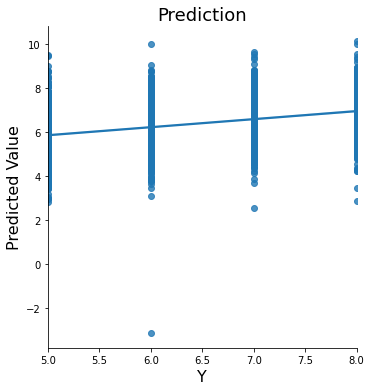

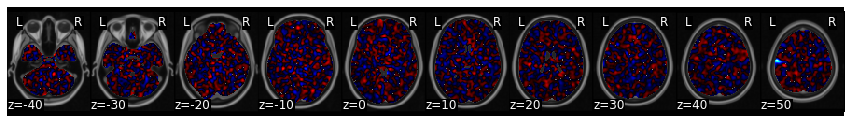

In [7]:
prediction_across_subjects = Brain_Data_allsubs_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_nn.X.subject})

#print(prediction_across_subjects)


#### get mask

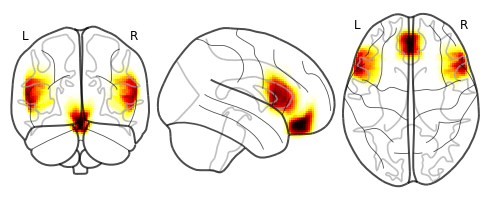

In [8]:
from nilearn.plotting import plot_glass_brain
from nilearn.masking import compute_brain_mask


mask_series = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Frontal Medial Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis.nii.gz"])

mask_aggregate_nifti= mask_series.sum().to_nifti()
plot_glass_brain(mask_aggregate_nifti)


In [9]:
np.histogram(mask_aggregate_nifti.get_fdata())

(array([894787,   2702,   1455,   1195,    753,    703,    518,    308,
           124,     84]),
 array([ 0. ,  9.6, 19.2, 28.8, 38.4, 48. , 57.6, 67.2, 76.8, 86.4, 96. ]))

In [10]:
np.sum(mask_aggregate_nifti.get_fdata()>1)

13251

In [11]:
np.sum(mask_aggregate_nifti.get_fdata()>10)

7491

In [12]:
np.sum(mask_aggregate_nifti.get_fdata()>25)

4138

In [13]:
mask_binarized = nil.image.new_img_like(mask_aggregate_nifti,(mask_aggregate_nifti.get_fdata()>5).astype(float))

#### apply mask

In [14]:
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))

3690
3840


#### CV on just regions of interest

In [15]:
Brain_Data_allsubs_masked_nn = Brain_Data_allsubs_nn.apply_mask(mask_binarized,resample_mask_to_brain=True)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.45619e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.9216e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.87109e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.659e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignat

overall Root Mean Squared Error: 0.20
overall Correlation: 0.98
overall CV Root Mean Squared Error: 2.79
overall CV Correlation: 0.05


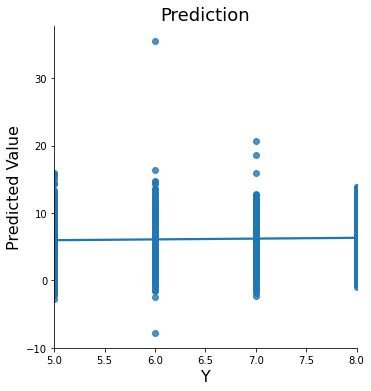

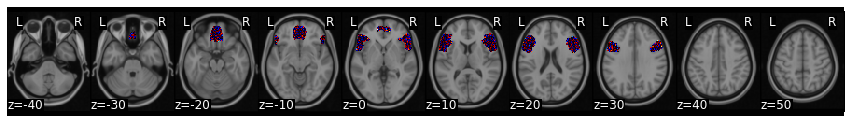

In [16]:
prediction_across_subjects = Brain_Data_allsubs_masked_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_nn.X.subject})

#print(prediction_across_subjects)


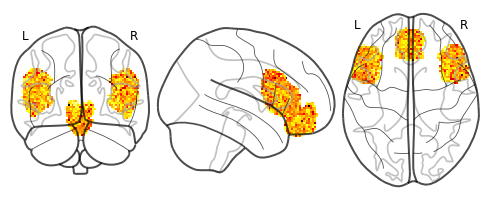

In [17]:
plot_glass_brain(prediction_across_subjects['weight_map'].to_nifti())

In [18]:
display = plotting.plot_stat_map(
    weight_map,
    title='Statistical weight map for whole brain prediction',
                             cut_coords=[-48, -18, 58])


NameError: name 'weight_map' is not defined

This particular position has a strong association with 'finger' in neurosynth so that all checks out. We'll need to remove this if we are going to get a meaningful signature!

 - I suspect even if we look at the pre-selection activity, at least after the haemodynamic convolution, we're going to see some finger activity blurred in to the selection.
 - For a whole-brain 'neural signature', we really...need the whole brain! Even if we look at foods that are 'liked', we're going to have a correlation with the WTP selection and thus with the finger-press.


Let's go through our options

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.00512e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.76089e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.66054e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.0404e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.33
overall Correlation: 0.95
overall CV Root Mean Squared Error: 2.54
overall CV Correlation: 0.05


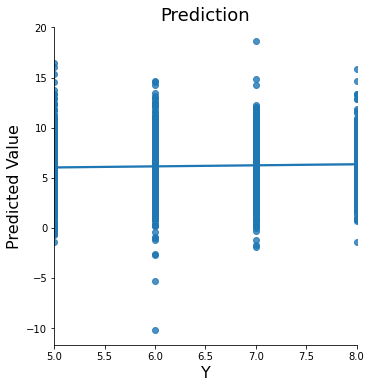

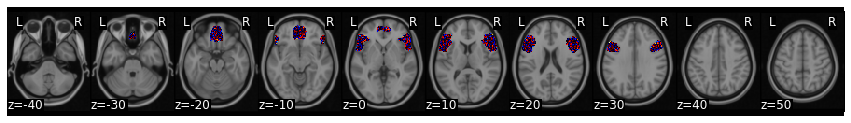

In [36]:
prediction_across_subjects = Brain_Data_allsubs_masked_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_masked_nn.X.subject})

#print(prediction_across_subjects)


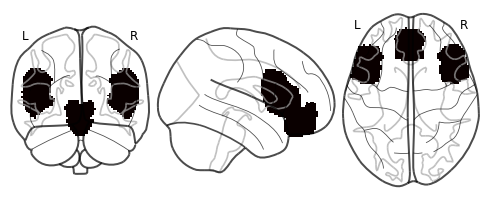

In [16]:
plot_glass_brain(mask_binarized)

### 'Virtual lesion' approach

I examined the above mask in FSLeyes and observed that, the most strongly indicative pieces of activity were in locations related in neurosynth.org most strongly with the visual cortex (particulalry V1) or the somatosensory cortex (particularly that related to the fingers). So to remove these from the analysis we can remove regions that overlap with those.

We can try masking using the following Harvard-Oxford masks:

 - Visual areas (intracalcarine cortex and occipital pole)
 - Somatosensory cortex (precentral gyrus, postcentral gyrus)

#### Attempt 1.

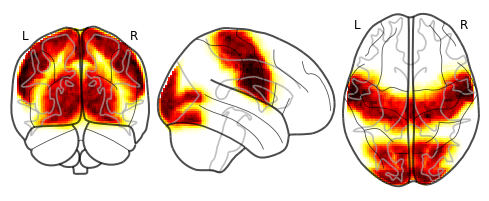

In [52]:
virtual_lesion_mask_series = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Occipital Pole.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Intracalcarine Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Precentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Postcentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Occipital Fusiform Gyrus.nii.gz"])


virtual_lesion_aggregate_nifti= virtual_lesion_mask_series.sum().to_nifti()
plot_glass_brain(virtual_lesion_aggregate_nifti)


In [53]:
virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti,
    (virtual_lesion_aggregate_nifti.get_fdata()<=0).astype(float))

In [54]:
nib.save(virtual_lesion_binarized,'../data/virtual_lesion_1.nii.gz')

In [35]:
Brain_Data_allsubs_vl_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.56144e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.70084e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.72276e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.52098e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.41
overall CV Correlation: 0.19


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


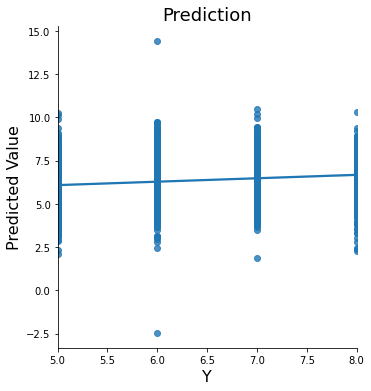

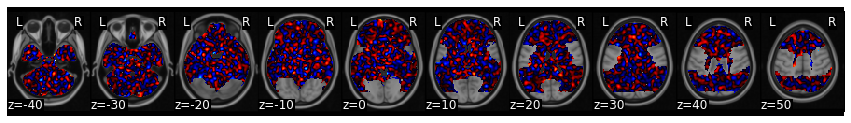

In [36]:
prediction_across_subjects = Brain_Data_allsubs_vl_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl_nn.X.subject})

#print(prediction_across_subjects)



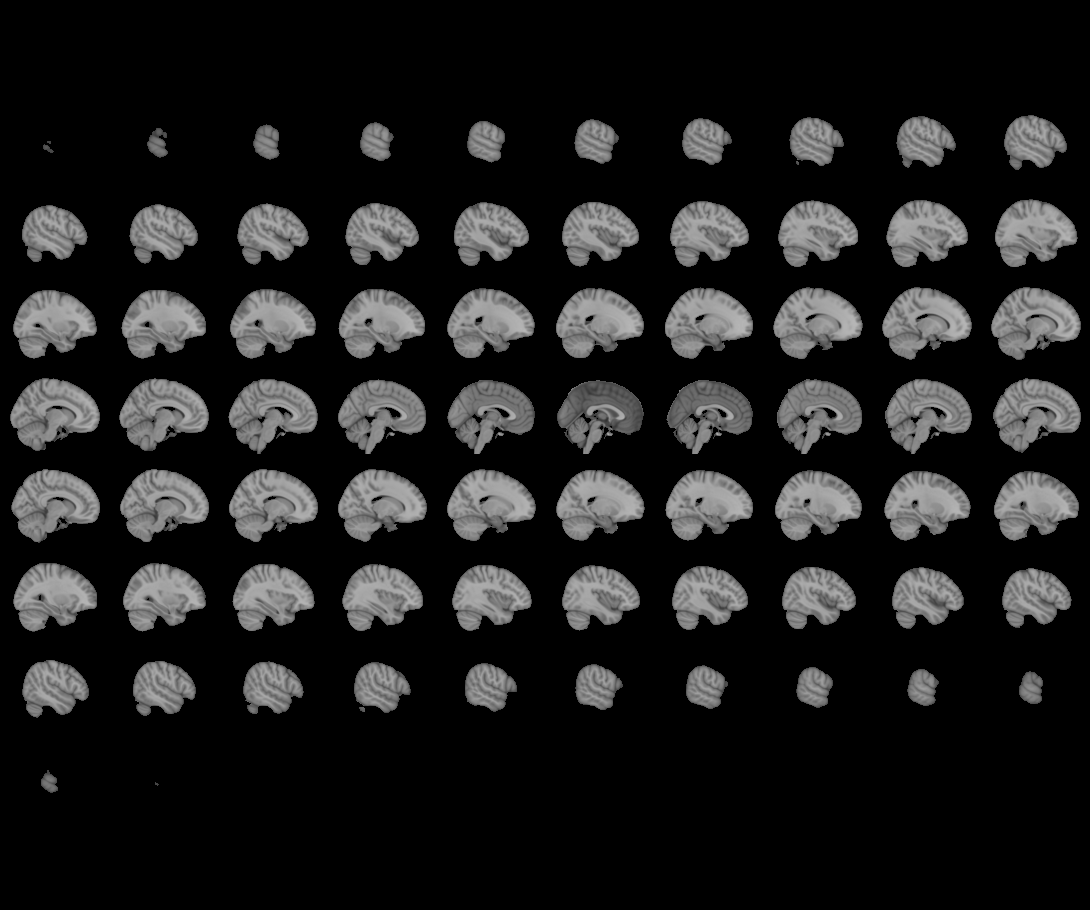
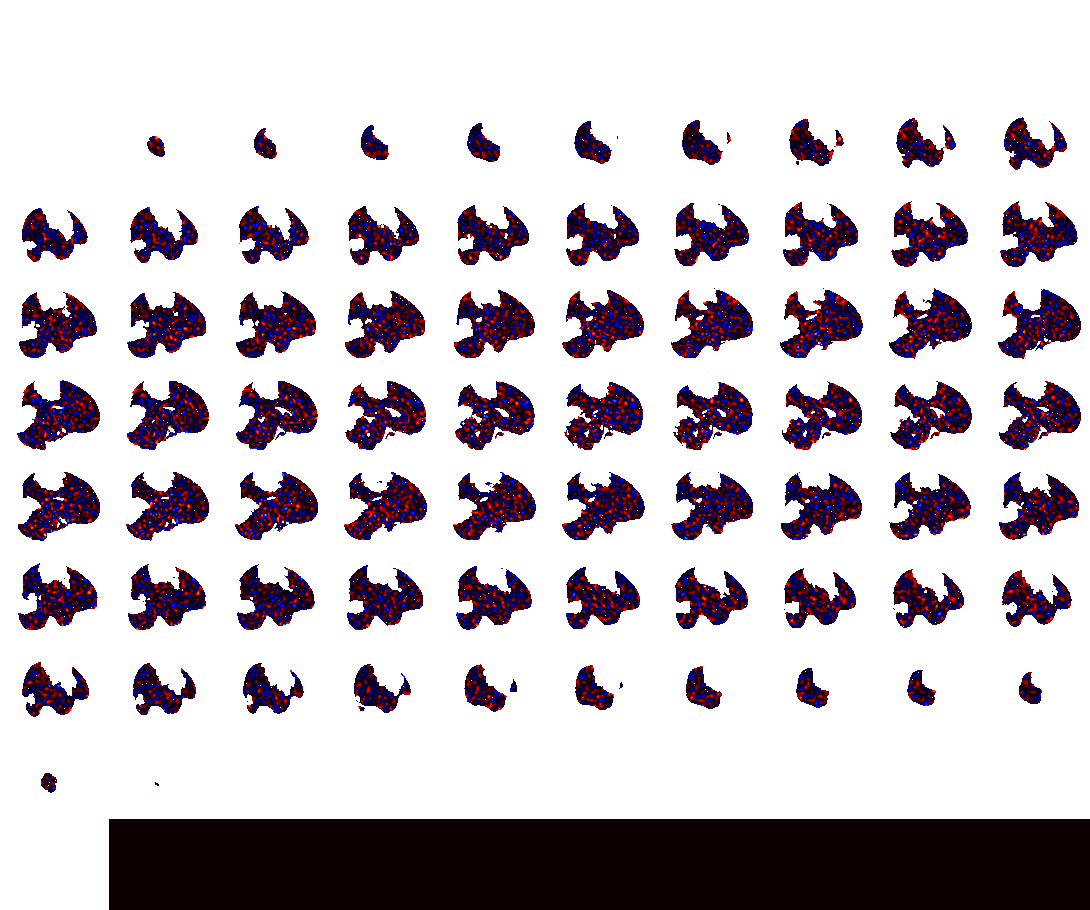

In [37]:
from nilearn import plotting

plotting.view_img(prediction_across_subjects['weight_map'].to_nifti())

Peak predictivity appears to be dorsomedial prefrontal cortex which is pretty cool. Also, semantic processing (IFG) and vmPFC. Some visual-associated areas continue to be implicated.

In [38]:
nib.save(prediction_across_subjects['weight_map'].to_nifti(),'../data/Brain_Data_2sns_60subs_with_virtual_lesion_1.nii.gz')

#### Attempt 2.

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



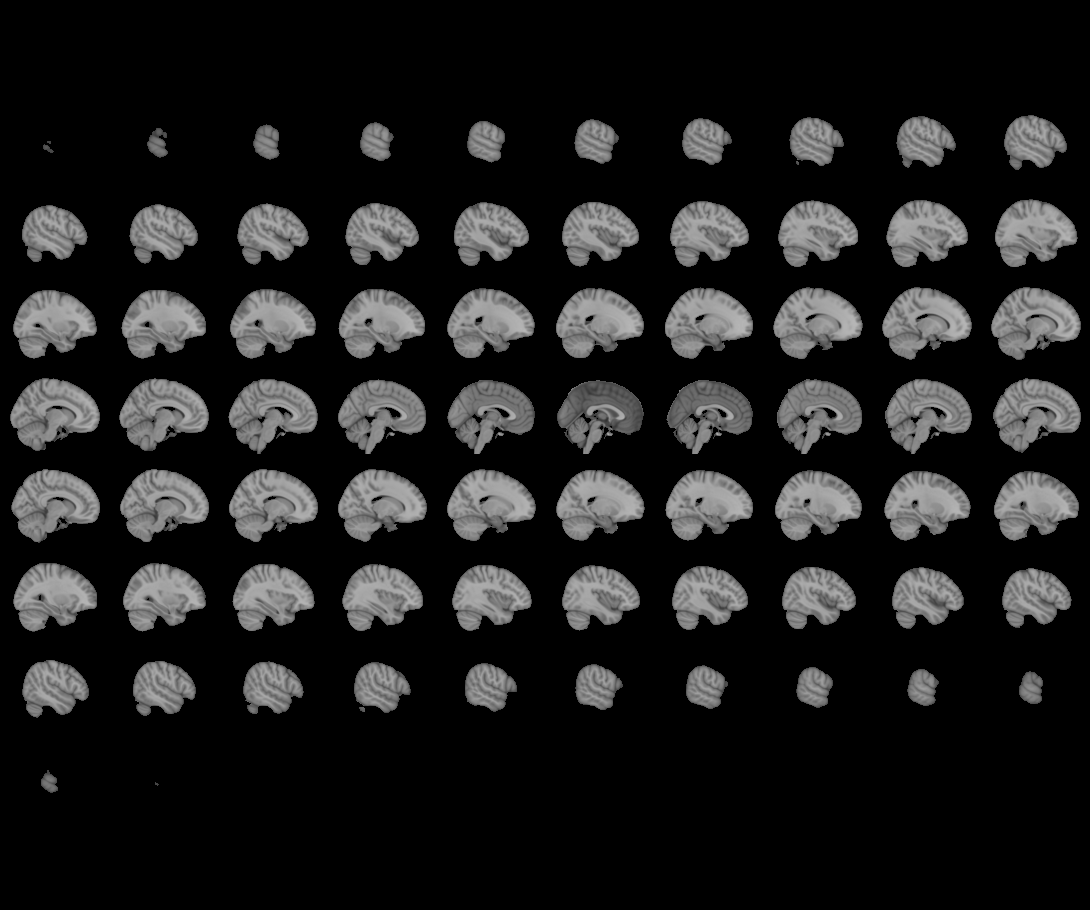
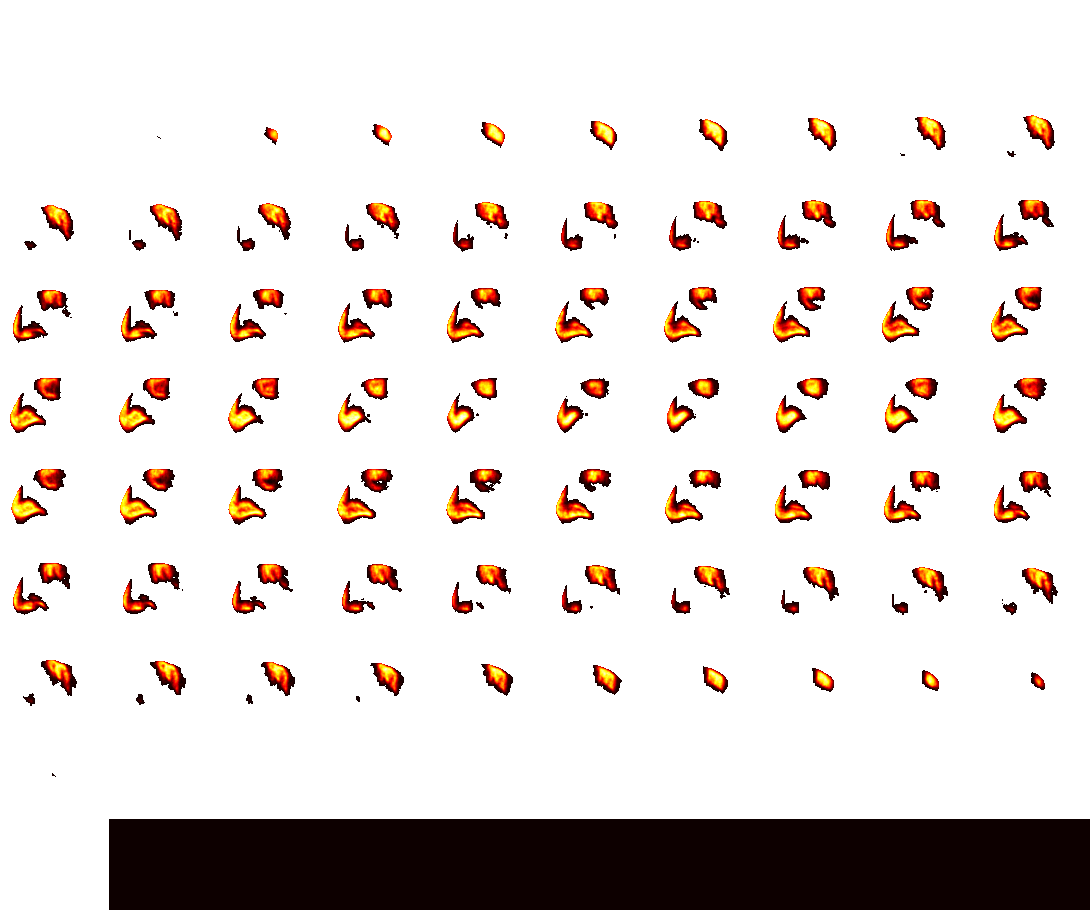

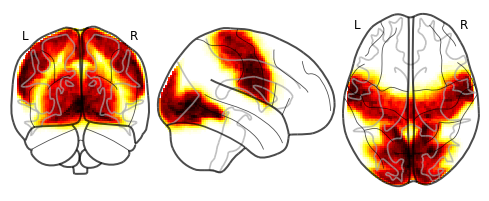

In [56]:
virtual_lesion_mask_series2 = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Occipital Pole.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Intracalcarine Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Precentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Postcentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Occipital Fusiform Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Lingual Gyrus.nii.gz"
    ])


virtual_lesion_aggregate_nifti= virtual_lesion_mask_series2.sum().to_nifti()
plot_glass_brain(virtual_lesion_aggregate_nifti)

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti,
    (virtual_lesion_aggregate_nifti.get_fdata()<=0).astype(float))

Brain_Data_allsubs_vl2_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti)

In [57]:
nib.save(virtual_lesion_binarized,'../data/virtual_lesion_2.nii.gz')


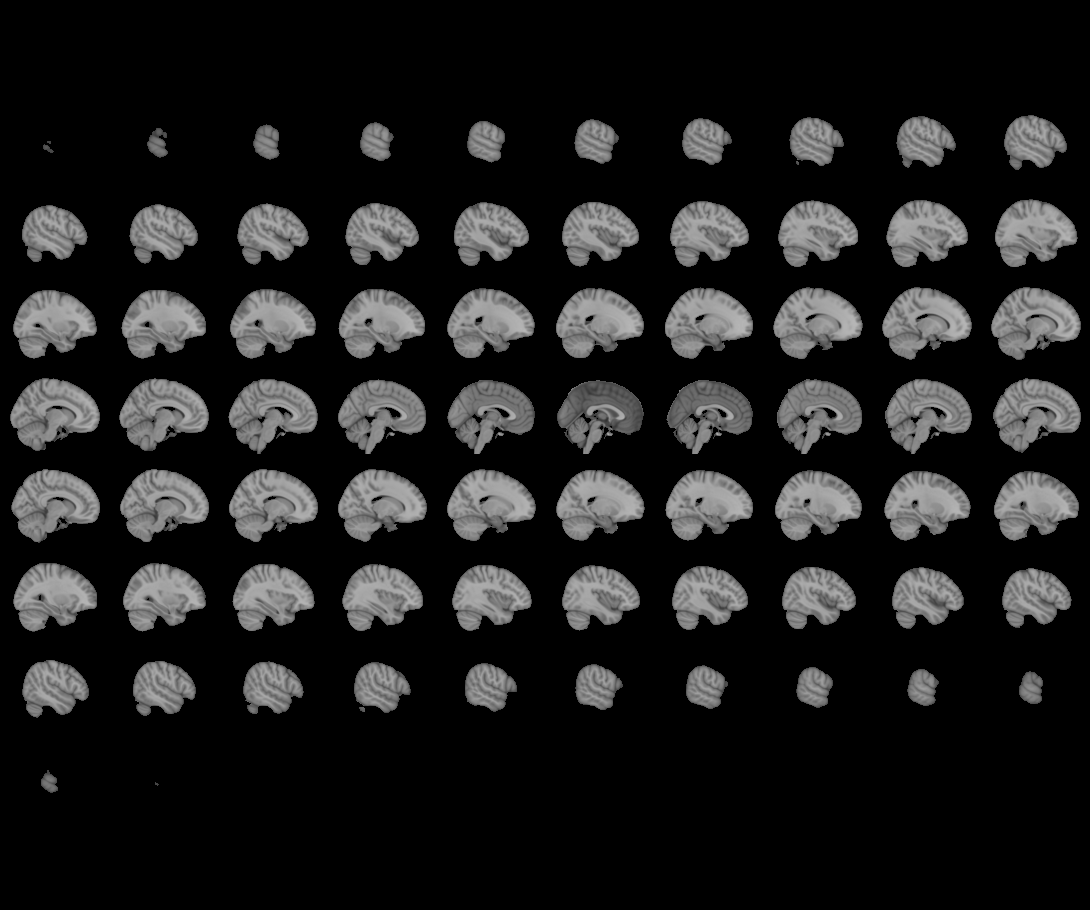
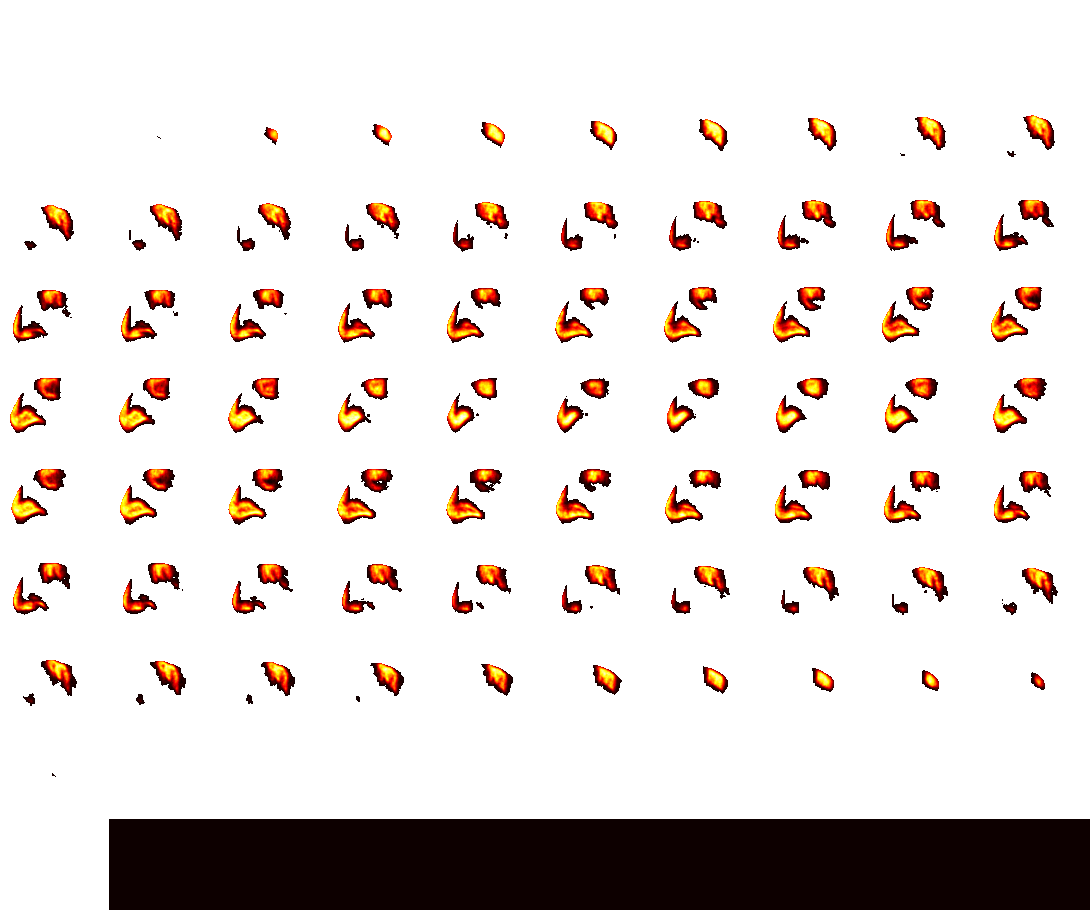

In [40]:
from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.06803e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.00337e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.07224e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.46097e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.41
overall CV Correlation: 0.19


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


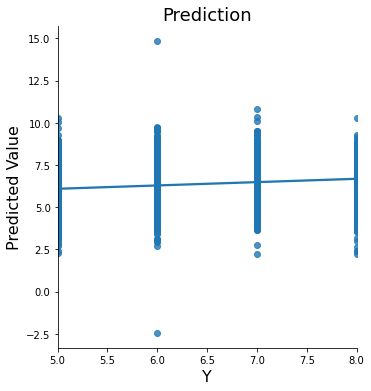

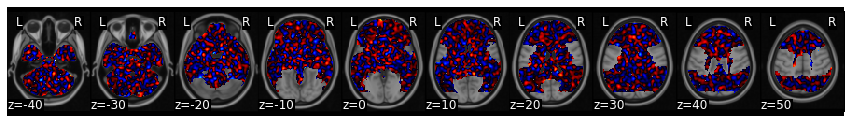

In [41]:
prediction_across_subjects = Brain_Data_allsubs_vl2_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl2_nn.X.subject})

#print(prediction_across_subjects)



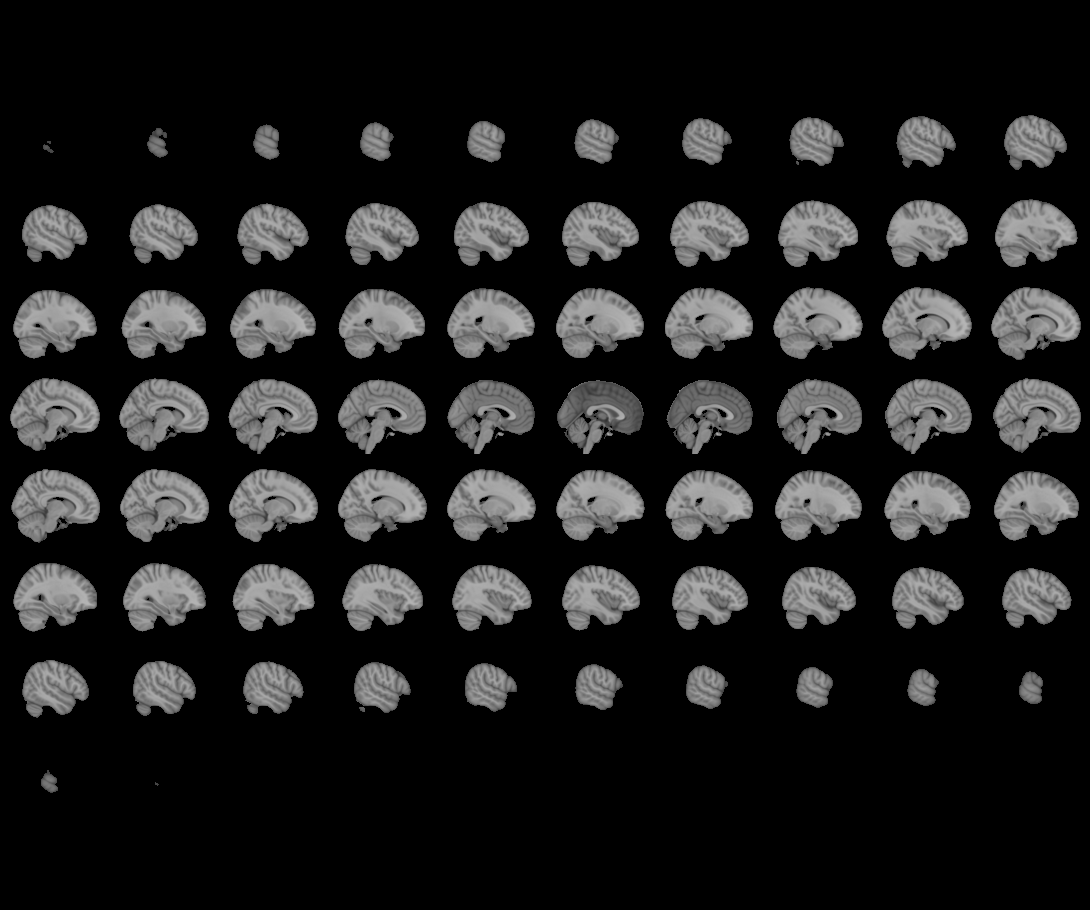
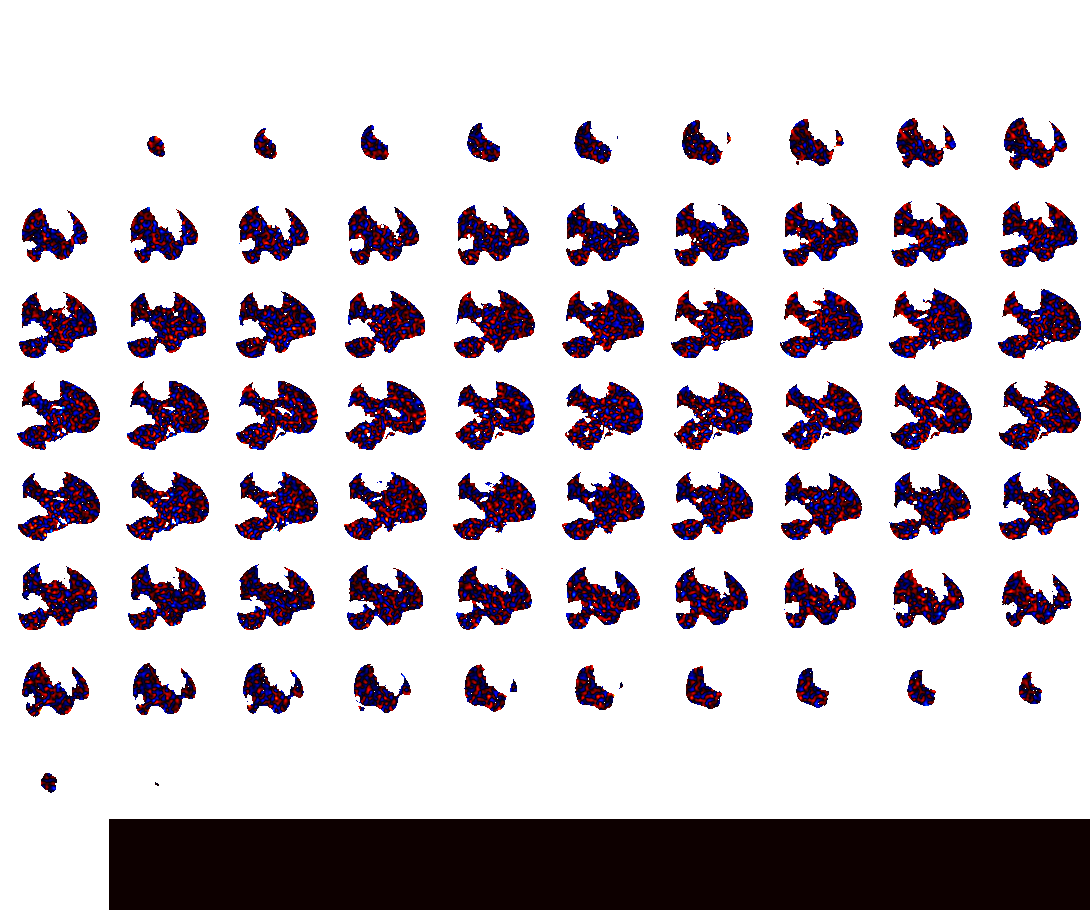

In [42]:
from nilearn import plotting

plotting.view_img(prediction_across_subjects['weight_map'].to_nifti())

In [43]:
nib.save(prediction_across_subjects['weight_map'].to_nifti(),
         '../data/Brain_Data_2sns_60subs_with_virtual_lesion_2.nii.gz')

#### Attempt 3

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



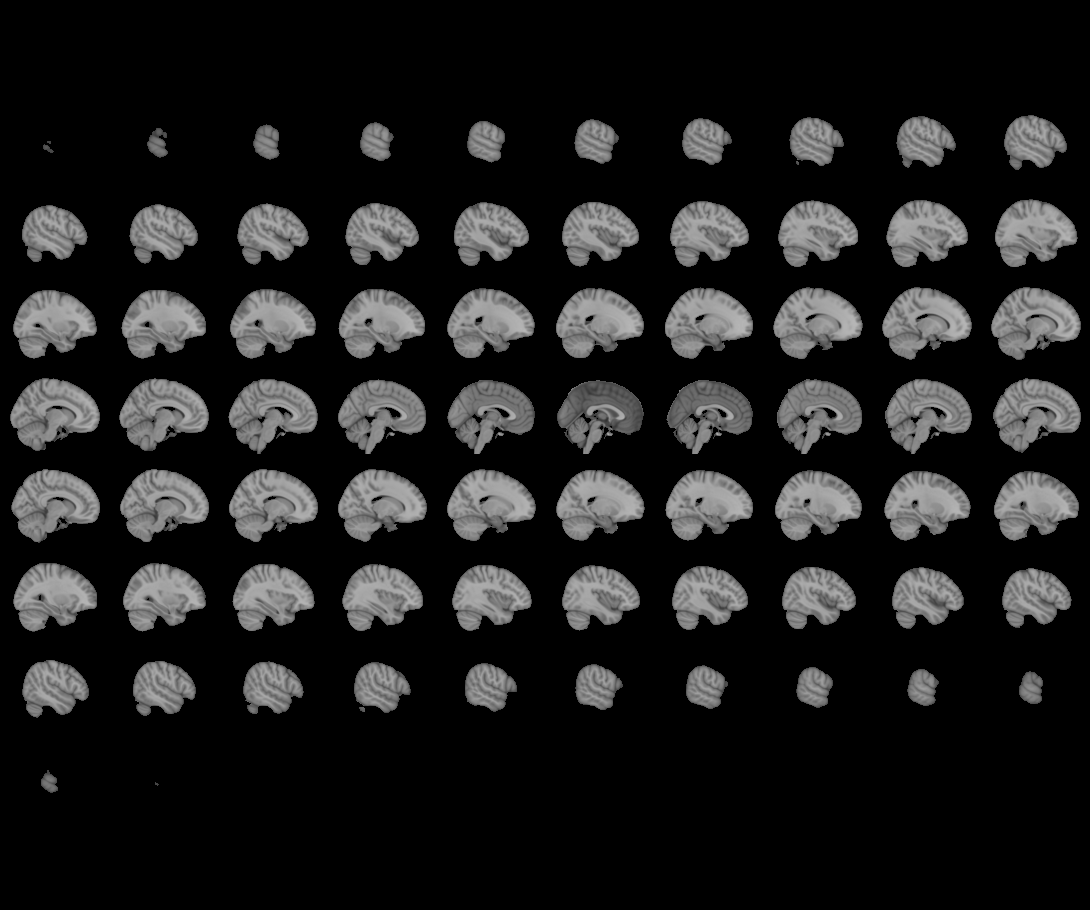
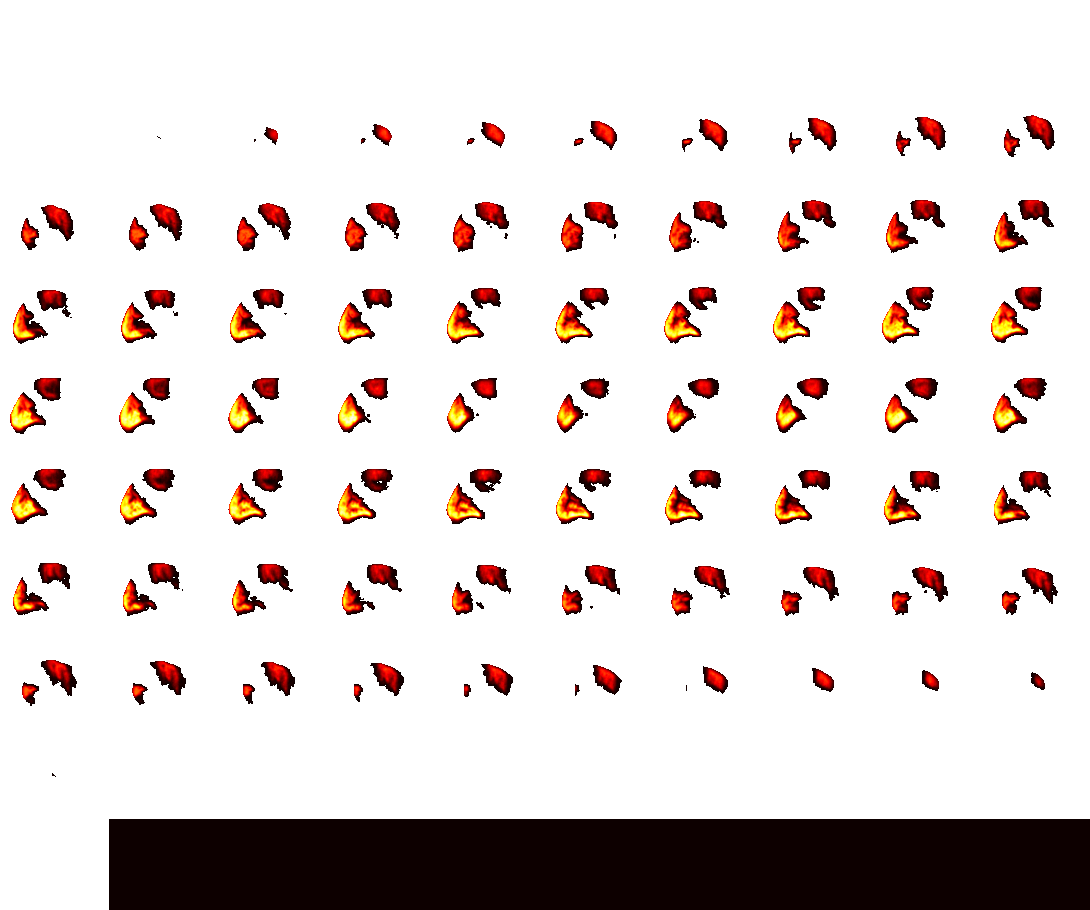

In [58]:
virtual_lesion_mask_series3 = nlt.Brain_Data(
    ["../data/masks/harvardoxford-cortical_prob_Occipital Pole.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Intracalcarine Cortex.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Precentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Postcentral Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Occipital Fusiform Gyrus.nii.gz",
    "../data/masks/harvardoxford-cortical_prob_Lingual Gyrus.nii.gz",
     "../data/masks/mni_prob_Occipital Lobe.nii.gz"
    ])


virtual_lesion_aggregate_nifti3= virtual_lesion_mask_series3.sum().to_nifti()

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti3,
    (virtual_lesion_aggregate_nifti3.get_fdata()<=0).astype(float))


Brain_Data_allsubs_vl3_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti3)

In [59]:
nib.save(virtual_lesion_binarized,'../data/virtual_lesion_3.nii.gz')

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.2379e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04678e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.87479e-11): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.64211e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.02
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.42
overall CV Correlation: 0.19


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


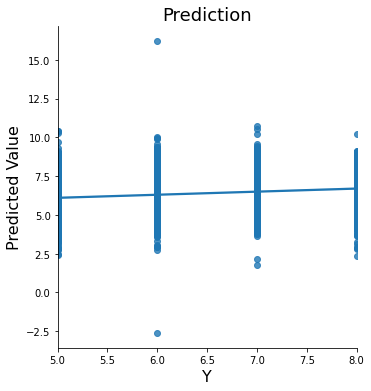

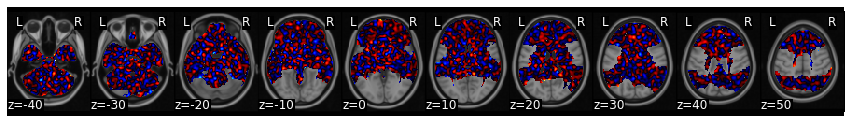

In [45]:
prediction_across_subjects = Brain_Data_allsubs_vl3_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl3_nn.X.subject})

#print(prediction_across_subjects)


In [46]:
nib.save(prediction_across_subjects['weight_map'].to_nifti(),
         '../data/Brain_Data_2sns_60subs_with_virtual_lesion_3.nii.gz')

#### Attempt 4

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



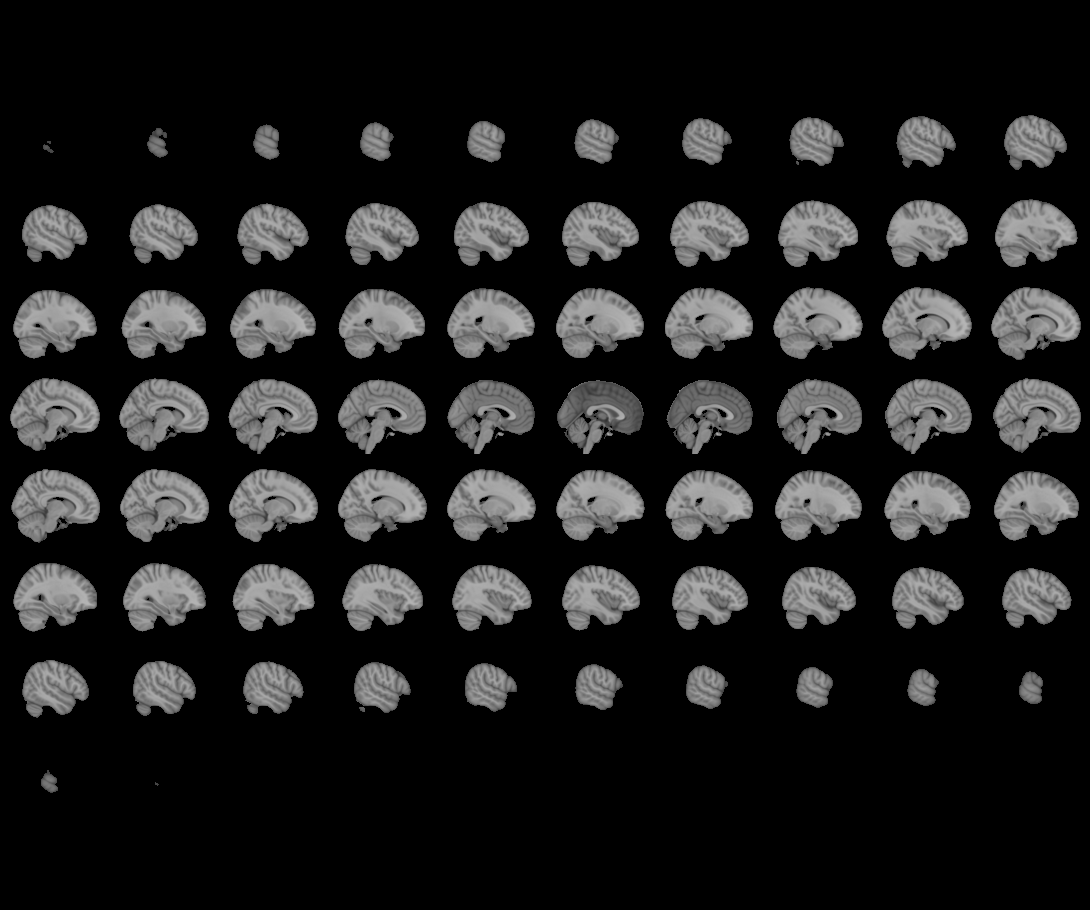
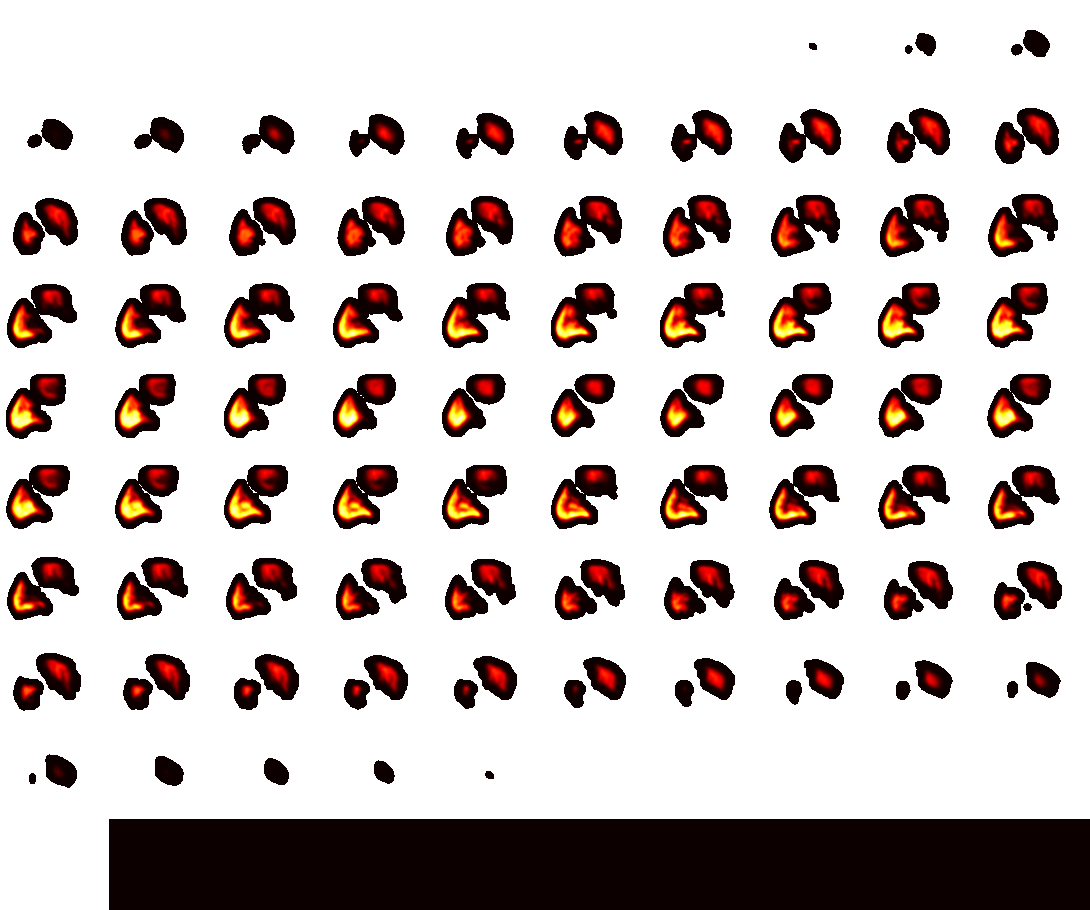

In [47]:
virtual_lesion_aggregate_nifti4 = nil.image.smooth_img(virtual_lesion_aggregate_nifti3,5)

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti4,
    (virtual_lesion_aggregate_nifti4.get_fdata()<=0).astype(float))


Brain_Data_allsubs_vl4_nn = Brain_Data_allsubs_nn.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti4)


In [60]:
nib.save(virtual_lesion_binarized,'../data/virtual_lesion_4.nii.gz')

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11751e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.3052e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.586e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.50634e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignat

overall Root Mean Squared Error: 0.01
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.57
overall CV Correlation: 0.15


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


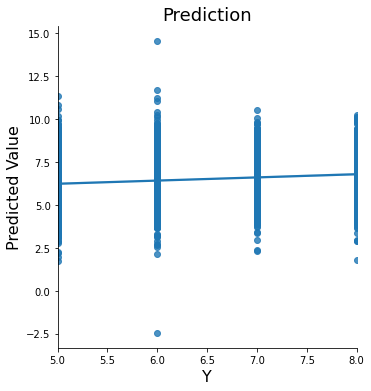

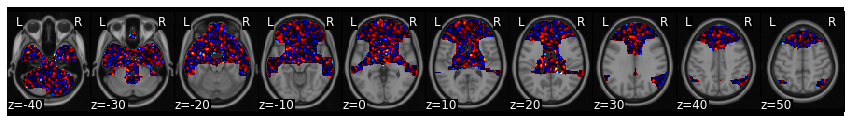

In [48]:
prediction_across_subjects = Brain_Data_allsubs_vl4_nn.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs_vl4_nn.X.subject})

#print(prediction_across_subjects)


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



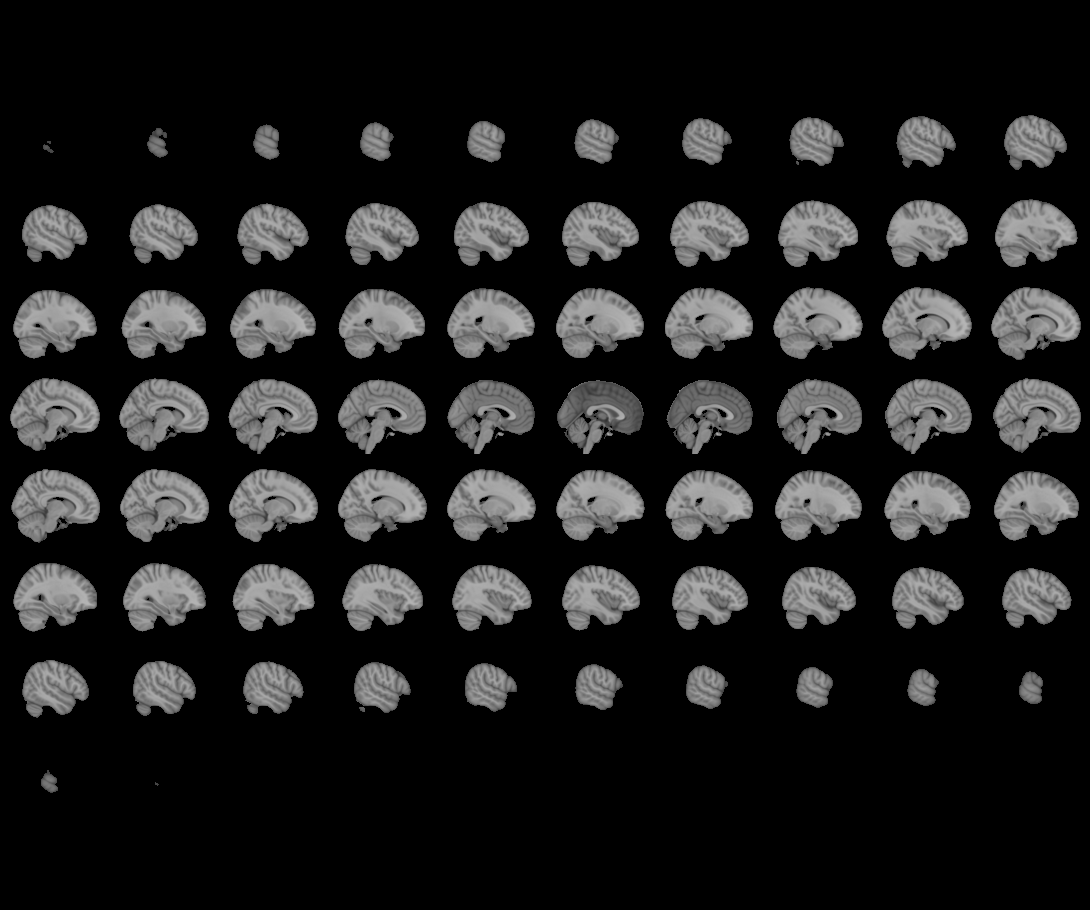
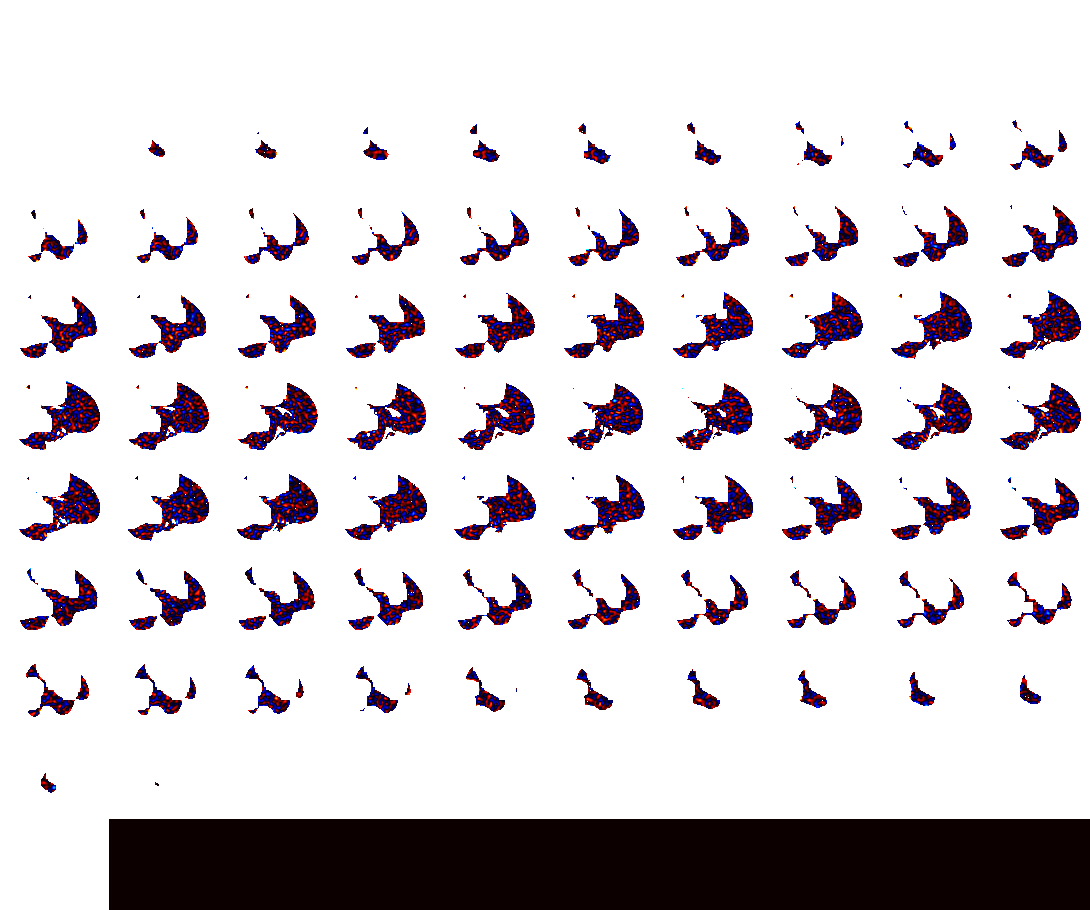

In [49]:
plotting.view_img(prediction_across_subjects['weight_map'].to_nifti())

In [50]:
nib.save(prediction_across_subjects['weight_map'].to_nifti(),
         '../data/Brain_Data_2sns_60subs_with_virtual_lesion_4.nii.gz')

## Conclusion

These betas seem to have better information than previously. Although somatosensory activity still dominates when unmasked, a small mask around the somatosensory area and visual cortex (attempt 3) yields a dataset that is predictive in areas that don't appear to be proximal to visual or somatosensory areas. This might give us something to go on.

However, we still do need to mask somatosensory areas.

## Group values together within runs

In [19]:
behavioral_design = Brain_Data_allsubs_nn.X.copy()
grouping_var_list=['response']
run_data_list = ['type','run','wave','subject']
#for each beta, get the key designating which group it belongs to
behavioral_design_group_key = behavioral_design[run_data_list + grouping_var_list]
#now just get a list of the groups from that
grouped_subj_behavioral_design = behavioral_design_group_key.drop_duplicates().reset_index(drop=True)

In [24]:
bd_list = []
#go through each group
for row_i in range(grouped_subj_behavioral_design.shape[0]):
    #pull the rows of the original design that are within the group
    print(str(row_i) + ", ",end='')
    beta_group = grouped_subj_behavioral_design.iloc[row_i,:]
    betas_in_group = (behavioral_design_group_key==beta_group).all(axis=1)

    #filter on that
    if(betas_in_group.sum()>1):
        group_beta = Brain_Data_allsubs_nn[betas_in_group].mean()
    else:
        group_beta = Brain_Data_allsubs_nn[betas_in_group]
    bd_list = bd_list + [group_beta]
    
    
    
    
    #img_list = Brain_Data_allsubs_nn[]

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [25]:
bd_grouped = nlt.utils.concatenate(bd_list)
bd_grouped.X=grouped_subj_behavioral_design


In [26]:
with open('../data/Brain_Data_2sns_60subs_grouped.pkl', 'wb') as pkl_file:
    pickle.dump(bd_grouped,pkl_file)

In [30]:
bd_grouped.Y = bd_grouped.X.response.copy()
print(bd_grouped.Y.value_counts())

6.0    236
7.0    235
5.0    227
8.0    202
Name: response, dtype: int64


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.00184e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.99597e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.23283e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2883e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.01
overall CV Correlation: 0.53


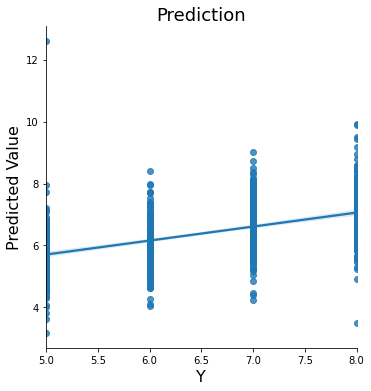

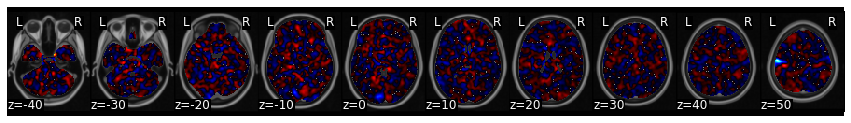

In [31]:
prediction_across_subjects = bd_grouped.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':bd_grouped.X.subject})

#print(prediction_across_subjects)


OK, that's the best we've seen so far, although I'd like to see how it would perform training on averaged data and testing on un-averaged data. That's probably the proper way to go about this.

Also important to understand: how would this go with somatosensory area blocked?


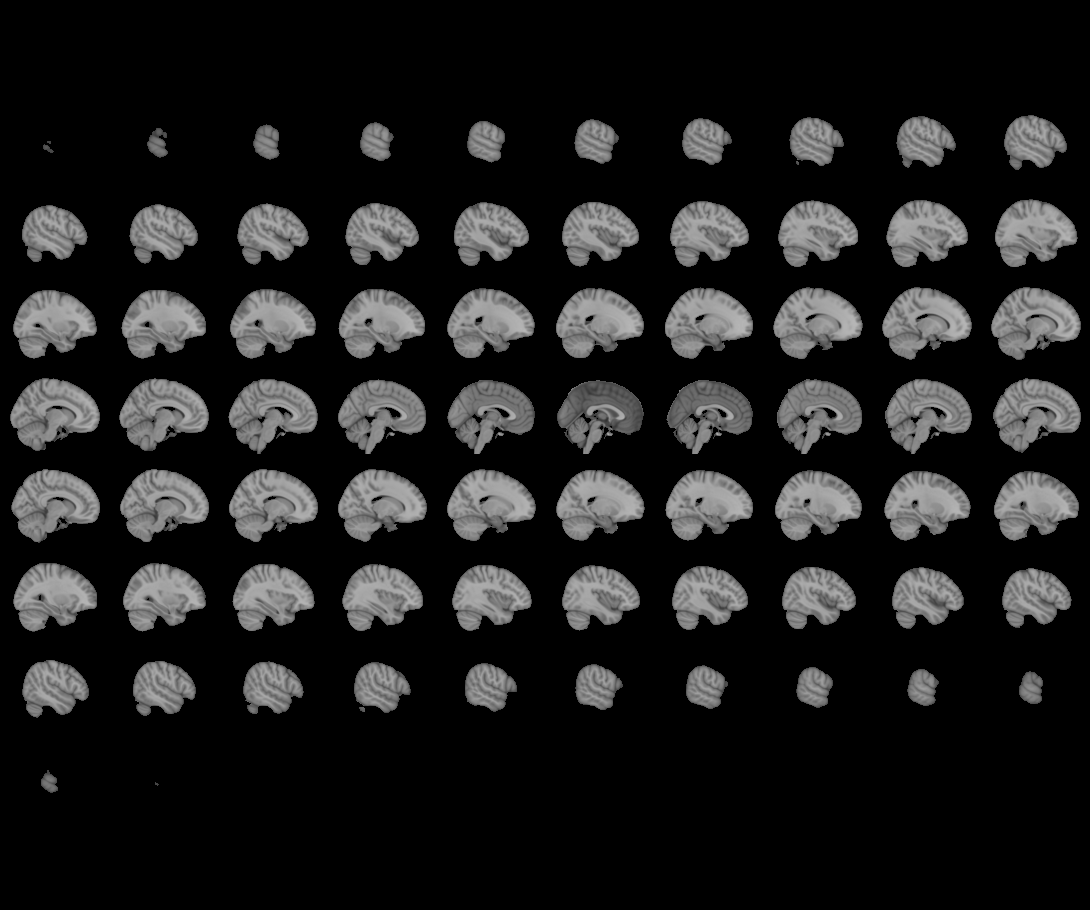
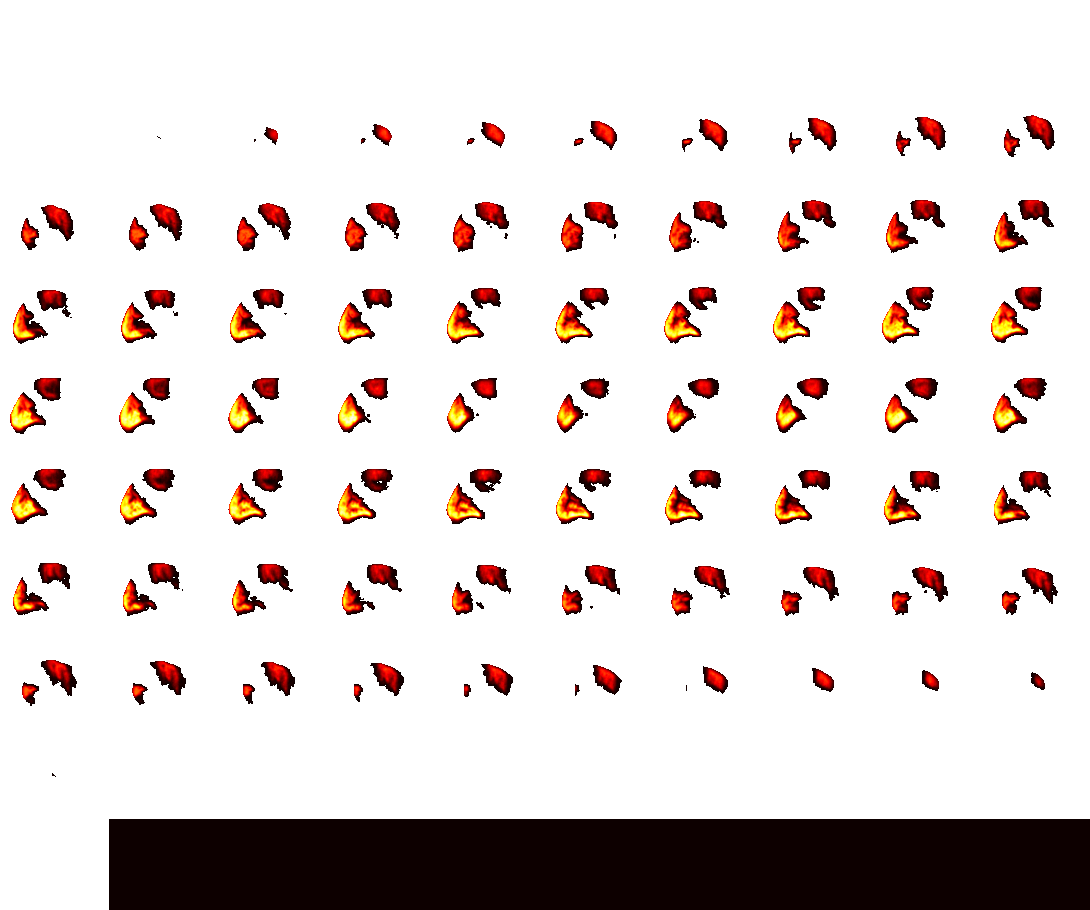

In [37]:
virtual_lesion_aggregate_nifti3= virtual_lesion_mask_series3.sum().to_nifti()

virtual_lesion_binarized = nil.image.new_img_like(
    virtual_lesion_aggregate_nifti3,
    (virtual_lesion_aggregate_nifti3.get_fdata()<=0).astype(float))


bd_grouped_masked = bd_grouped.apply_mask(virtual_lesion_binarized,resample_mask_to_brain=False)

from nilearn import plotting

plotting.view_img(virtual_lesion_aggregate_nifti3)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.11322e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.39358e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.45666e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.41921e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsig

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.20
overall CV Correlation: 0.34


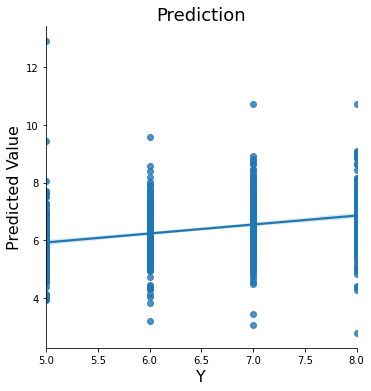

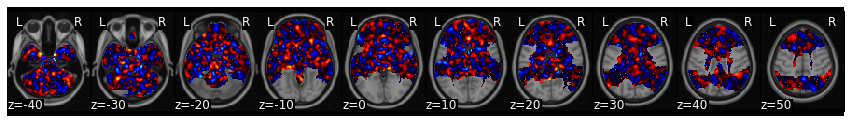

In [38]:
prediction_across_subjects = bd_grouped_masked.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':bd_grouped_masked.X.subject})

#print(prediction_across_subjects)


In [40]:
prediction_across_subjects.keys()

dict_keys(['Y', 'yfit_all', 'intercept', 'weight_map', 'yfit_xval', 'intercept_xval', 'weight_map_xval', 'cv_idx', 'rmse_all', 'r_all', 'rmse_xval', 'r_xval'])

In [41]:
prediction_across_subjects['r_xval']

0.34338272606296844